# **Bài tập phân loại học sinh - Student Classification**
## **Sinh viên: Nguyễn Văn Anh Duy**
## **MSSV: SE181823**
## **CLASS: AI1803**

### **Mục tiêu:**
- Xây dựng mô hình phân loại học sinh thành 2 nhóm: **Good** và **Normal**
- Sử dụng TensorFlow với kiến trúc Sequential
- Output layer sử dụng sigmoid activation
- Tỷ lệ train/test: 70/30

## 1. Import thư viện cần thiết

In [22]:
# Import các thư viện cần thiết cho bài toán phân loại
import pandas as pd  # Đọc và xử lý dữ liệu dạng bảng
import numpy as np  # Xử lý mảng và tính toán số học
import matplotlib.pyplot as plt  # Vẽ biểu đồ
import seaborn as sns  # Vẽ biểu đồ nâng cao
from sklearn.model_selection import train_test_split  # Chia dữ liệu train/test
from sklearn.preprocessing import LabelEncoder, StandardScaler  # Chuẩn hóa dữ liệu

# Import TensorFlow và Keras để xây dựng mô hình Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential  # Mô hình tuần tự (layer-by-layer)
from tensorflow.keras.layers import Dense, Dropout  # Các layer cơ bản
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Callback để tối ưu training

# Hiển thị phiên bản TensorFlow
print(f"TensorFlow version: {tf.__version__}")

# Set seed cho reproducibility (kết quả nhất quán)
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow version: 2.19.0


## 2. Load và khám phá dữ liệu (Data Exploration)

In [23]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv('/content/gpa_study_hours.csv')

# Hiển thị thông tin cơ bản về dataset
print("=" * 60)
print("THÔNG TIN CƠ BẢN VỀ DATASET")
print("=" * 60)
print(f"\nSố lượng mẫu (samples): {len(df)}")
print(f"Số lượng đặc trưng (features): {df.shape[1] - 1}")  # -1 vì có 1 cột target
print(f"\nCác cột trong dataset:")
print(df.columns.tolist())

# Hiển thị 10 dòng đầu tiên
print("\n" + "=" * 60)
print("10 DÒNG ĐẦU TIÊN CỦA DATASET")
print("=" * 60)
print(df.head(10))

# Kiểm tra thông tin chi tiết
print("\n" + "=" * 60)
print("THÔNG TIN CHI TIẾT")
print("=" * 60)
print(df.info())

# Kiểm tra giá trị null
print("\n" + "=" * 60)
print("KIỂM TRA GIÁ TRỊ NULL")
print("=" * 60)
print(df.isnull().sum())

# Thống kê mô tả
print("\n" + "=" * 60)
print("THỐNG KÊ MÔ TẢ")
print("=" * 60)
print(df.describe())

THÔNG TIN CƠ BẢN VỀ DATASET

Số lượng mẫu (samples): 193
Số lượng đặc trưng (features): 2

Các cột trong dataset:
['gpa', 'study_hours', 'rank']

10 DÒNG ĐẦU TIÊN CỦA DATASET
    gpa  study_hours    rank
0  4.00         10.0    Good
1  3.80         25.0    Good
2  3.93         45.0    Good
3  3.40         10.0  Normal
4  3.20          4.0  Normal
5  3.52         10.0  Normal
6  3.68         24.0  Normal
7  3.40         40.0  Normal
8  3.70         10.0    Good
9  3.75         10.0    Good

THÔNG TIN CHI TIẾT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gpa          193 non-null    float64
 1   study_hours  193 non-null    float64
 2   rank         193 non-null    object 
dtypes: float64(2), object(1)
memory usage: 4.7+ KB
None

KIỂM TRA GIÁ TRỊ NULL
gpa            0
study_hours    0
rank           0
dtype: int64

THỐNG KÊ MÔ TẢ
            

PHÂN TÍCH PHÂN BỐ NHÃN

Số lượng mỗi loại:
rank
Normal    108
Good       85
Name: count, dtype: int64

Tỷ lệ phần trăm:
Normal: 55.96%
Good: 44.04%


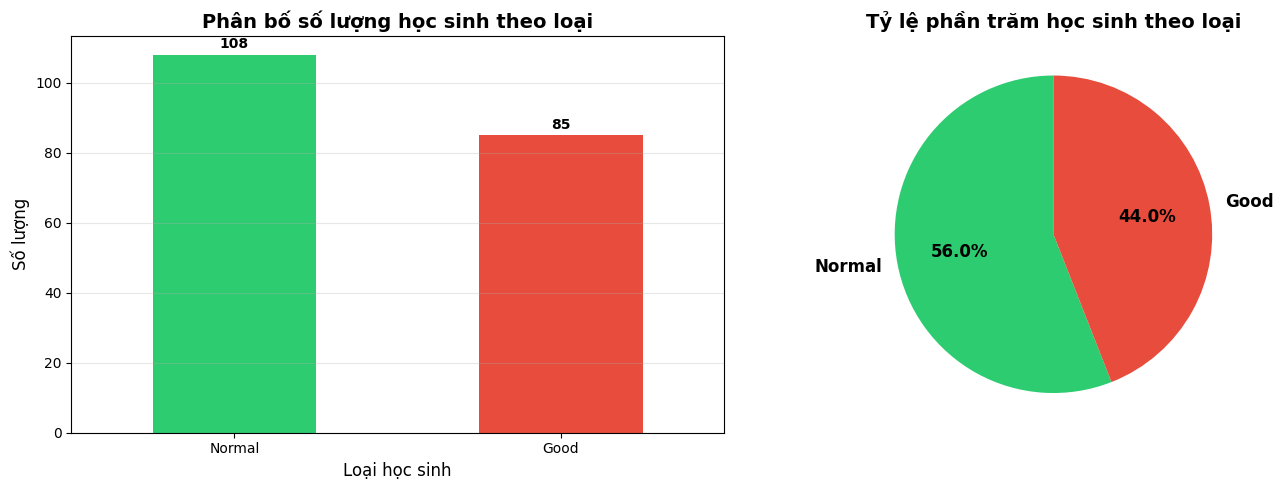

In [24]:
# Phân tích phân bố của nhãn (label distribution)
print("=" * 60)
print("PHÂN TÍCH PHÂN BỐ NHÃN")
print("=" * 60)

# Đếm số lượng từng loại
rank_counts = df['rank'].value_counts()
print("\nSố lượng mỗi loại:")
print(rank_counts)

# Tính tỷ lệ phần trăm
rank_percentage = df['rank'].value_counts(normalize=True) * 100
print("\nTỷ lệ phần trăm:")
for rank, percent in rank_percentage.items():
    print(f"{rank}: {percent:.2f}%")

# Vẽ biểu đồ phân bố
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ cột (bar chart)
rank_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Phân bố số lượng học sinh theo loại', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Loại học sinh', fontsize=12)
axes[0].set_ylabel('Số lượng', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Thêm số lượng lên trên mỗi cột
for i, v in enumerate(rank_counts):
    axes[0].text(i, v + 1, str(v), ha='center', va='bottom', fontweight='bold')

# Biểu đồ tròn (pie chart)
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(rank_counts, labels=rank_counts.index, autopct='%1.1f%%',
            startangle=90, colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Tỷ lệ phần trăm học sinh theo loại', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

/tmp/ipython-input-3628359092.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot([feature_data], positions=[position], widths=0.3,
/tmp/ipython-input-3628359092.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot([feature_data], positions=[position], widths=0.3,
/tmp/ipython-input-3628359092.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot([feature_data], positions=[position], widths=0.3,
/tmp/ipython-input-3628359092.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9

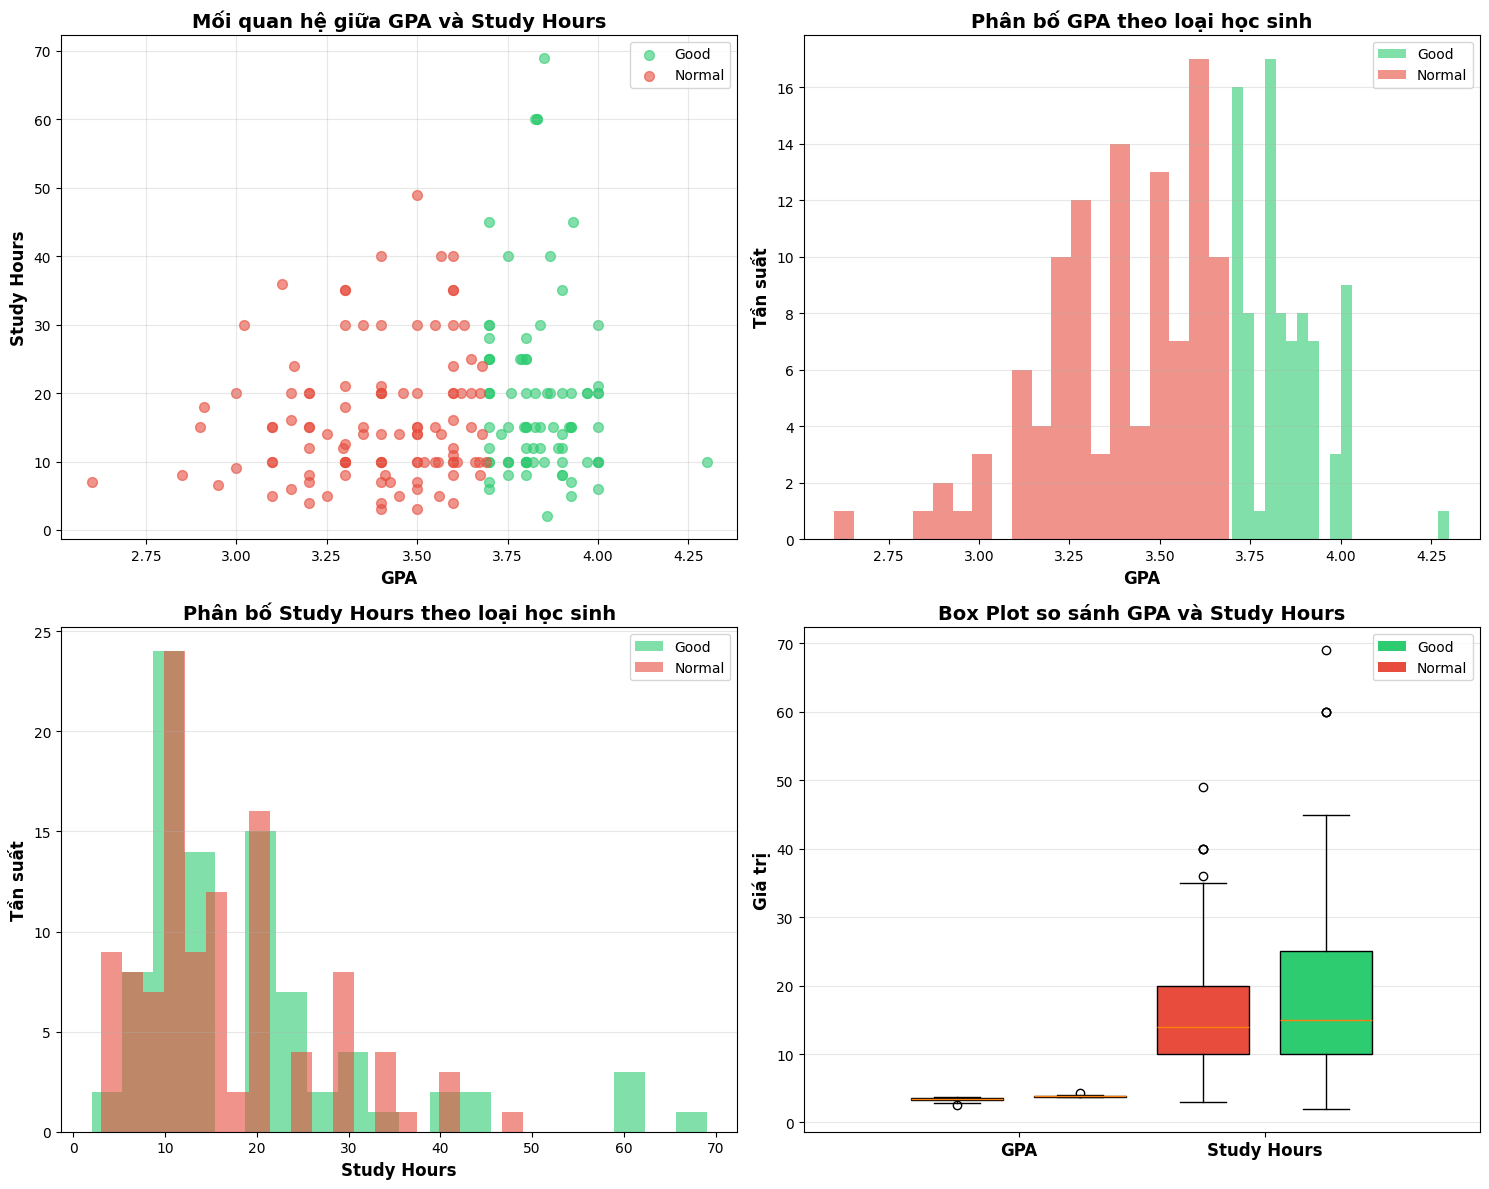


THỐNG KÊ THEO LOẠI HỌC SINH
          gpa                                                       \
        count      mean       std  min   25%    50%      75%   max   
rank                                                                 
Good     85.0  3.837200  0.108239  3.7  3.75  3.825  3.90000  4.30   
Normal  108.0  3.388593  0.218138  2.6  3.25  3.400  3.57525  3.69   

       study_hours                                                     
             count       mean        std  min   25%   50%   75%   max  
rank                                                                   
Good          85.0  19.188235  13.154299  2.0  10.0  15.0  25.0  69.0  
Normal       108.0  16.129630   9.673011  3.0  10.0  14.0  20.0  49.0  


In [25]:
# Vẽ biểu đồ phân tích mối quan hệ giữa các đặc trưng
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scatter plot: GPA vs Study Hours với màu theo rank
for rank in df['rank'].unique():
    mask = df['rank'] == rank
    color = '#2ecc71' if rank == 'Good' else '#e74c3c'
    axes[0, 0].scatter(df[mask]['gpa'], df[mask]['study_hours'],
                       label=rank, alpha=0.6, s=50, color=color)
axes[0, 0].set_xlabel('GPA', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Study Hours', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Mối quan hệ giữa GPA và Study Hours', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution plot: GPA theo rank
for rank in df['rank'].unique():
    mask = df['rank'] == rank
    color = '#2ecc71' if rank == 'Good' else '#e74c3c'
    axes[0, 1].hist(df[mask]['gpa'], bins=20, alpha=0.6, label=rank, color=color)
axes[0, 1].set_xlabel('GPA', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Tần suất', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Phân bố GPA theo loại học sinh', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Distribution plot: Study Hours theo rank
for rank in df['rank'].unique():
    mask = df['rank'] == rank
    color = '#2ecc71' if rank == 'Good' else '#e74c3c'
    axes[1, 0].hist(df[mask]['study_hours'], bins=20, alpha=0.6, label=rank, color=color)
axes[1, 0].set_xlabel('Study Hours', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Tần suất', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Phân bố Study Hours theo loại học sinh', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Box plot: So sánh GPA và Study Hours
df_melted = pd.melt(df, id_vars=['rank'], value_vars=['gpa', 'study_hours'],
                    var_name='Feature', value_name='Value')
for rank in df['rank'].unique():
    mask = df_melted['rank'] == rank
    data = df_melted[mask]
    color = '#2ecc71' if rank == 'Good' else '#e74c3c'

    for i, feature in enumerate(['gpa', 'study_hours']):
        feature_data = data[data['Feature'] == feature]['Value']
        position = i * 0.8 + (0.2 if rank == 'Good' else -0.2)
        bp = axes[1, 1].boxplot([feature_data], positions=[position], widths=0.3,
                                 patch_artist=True, labels=[''])
        for patch in bp['boxes']:
            patch.set_facecolor(color)

axes[1, 1].set_xticks([0, 0.8])
axes[1, 1].set_xticklabels(['GPA', 'Study Hours'], fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Giá trị', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Box Plot so sánh GPA và Study Hours', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

# Tạo legend tùy chỉnh
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ecc71', label='Good'),
                   Patch(facecolor='#e74c3c', label='Normal')]
axes[1, 1].legend(handles=legend_elements)

plt.tight_layout()
plt.show()

# In ra thống kê theo từng loại
print("\n" + "=" * 60)
print("THỐNG KÊ THEO LOẠI HỌC SINH")
print("=" * 60)
print(df.groupby('rank')[['gpa', 'study_hours']].describe())

## 3. Tiền xử lý dữ liệu (Data Preprocessing)

In [26]:
# Tách features (X) và target (y)
# X: các đặc trưng đầu vào (gpa, study_hours)
# y: nhãn cần dự đoán (rank)
X = df[['gpa', 'study_hours']].values  # Chuyển sang numpy array
y = df['rank'].values

print("=" * 60)
print("TÁCH DỮ LIỆU")
print("=" * 60)
print(f"Kích thước X (features): {X.shape}")
print(f"Kích thước y (target): {y.shape}")
print(f"\nVí dụ 5 mẫu đầu tiên của X:\n{X[:5]}")
print(f"\nVí dụ 5 mẫu đầu tiên của y:\n{y[:5]}")

# Encode nhãn từ text thành số
# Good -> 1, Normal -> 0
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("\n" + "=" * 60)
print("ENCODE NHÃN")
print("=" * 60)
print(f"Mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
print(f"Sau khi encode, 5 mẫu đầu tiên của y: {y_encoded[:5]}")

# Chuẩn hóa dữ liệu (Standardization)
# Công thức: z = (x - mean) / std
# Giúp model học tốt hơn khi các features có scale khác nhau
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n" + "=" * 60)
print("CHUẨN HÓA DỮ LIỆU (STANDARDIZATION)")
print("=" * 60)
print(f"Mean của features trước khi chuẩn hóa:\n{X.mean(axis=0)}")
print(f"Std của features trước khi chuẩn hóa:\n{X.std(axis=0)}")
print(f"\nMean của features sau khi chuẩn hóa:\n{X_scaled.mean(axis=0)}")
print(f"Std của features sau khi chuẩn hóa:\n{X_scaled.std(axis=0)}")
print(f"\nVí dụ 5 mẫu đầu tiên sau chuẩn hóa:\n{X_scaled[:5]}")

TÁCH DỮ LIỆU
Kích thước X (features): (193, 2)
Kích thước y (target): (193,)

Ví dụ 5 mẫu đầu tiên của X:
[[ 4.   10.  ]
 [ 3.8  25.  ]
 [ 3.93 45.  ]
 [ 3.4  10.  ]
 [ 3.2   4.  ]]

Ví dụ 5 mẫu đầu tiên của y:
['Good' 'Good' 'Good' 'Normal' 'Normal']

ENCODE NHÃN
Mapping: {'Good': np.int64(0), 'Normal': np.int64(1)}
Sau khi encode, 5 mẫu đầu tiên của y: [0 0 0 1 1]

CHUẨN HÓA DỮ LIỆU (STANDARDIZATION)
Mean của features trước khi chuẩn hóa:
[ 3.5861658  17.47668394]
Std của features trước khi chuẩn hóa:
[ 0.28474107 11.37938439]

Mean của features sau khi chuẩn hóa:
[-2.71975879e-15 -1.42660782e-16]
Std của features sau khi chuẩn hóa:
[1. 1.]

Ví dụ 5 mẫu đầu tiên sau chuẩn hóa:
[[ 1.45337026 -0.65703765]
 [ 0.75097772  0.66113559]
 [ 1.20753287  2.41869992]
 [-0.65380735 -0.65703765]
 [-1.35619989 -1.18430694]]


## 4. Chia dữ liệu thành Train/Test (70/30)

In [27]:
# Chia dữ liệu theo tỷ lệ 70% train, 30% test
# stratify=y_encoded: đảm bảo tỷ lệ Good/Normal giống nhau ở cả train và test set
# random_state=42: để kết quả reproducible
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_encoded,
    test_size=0.3,  # 30% cho test
    random_state=42,
    stratify=y_encoded  # Đảm bảo phân bố nhãn đồng đều
)

print("=" * 60)
print("CHIA DỮ LIỆU TRAIN/TEST (70/30)")
print("=" * 60)
print(f"\nTổng số mẫu: {len(X_scaled)}")
print(f"Số mẫu train: {len(X_train)} ({len(X_train)/len(X_scaled)*100:.1f}%)")
print(f"Số mẫu test: {len(X_test)} ({len(X_test)/len(X_scaled)*100:.1f}%)")

print(f"\nKích thước X_train: {X_train.shape}")
print(f"Kích thước X_test: {X_test.shape}")
print(f"Kích thước y_train: {y_train.shape}")
print(f"Kích thước y_test: {y_test.shape}")

# Kiểm tra phân bố nhãn trong train và test set
print("\n" + "=" * 60)
print("PHÂN BỐ NHÃN TRONG TRAIN VÀ TEST SET")
print("=" * 60)

train_unique, train_counts = np.unique(y_train, return_counts=True)
test_unique, test_counts = np.unique(y_test, return_counts=True)

print("\nTrain set:")
for label, count in zip(train_unique, train_counts):
    label_name = label_encoder.inverse_transform([label])[0]
    percentage = count / len(y_train) * 100
    print(f"  {label_name}: {count} mẫu ({percentage:.2f}%)")

print("\nTest set:")
for label, count in zip(test_unique, test_counts):
    label_name = label_encoder.inverse_transform([label])[0]
    percentage = count / len(y_test) * 100
    print(f"  {label_name}: {count} mẫu ({percentage:.2f}%)")

print("\nĐã chia dữ liệu thành train và test set thành công!")

CHIA DỮ LIỆU TRAIN/TEST (70/30)

Tổng số mẫu: 193
Số mẫu train: 135 (69.9%)
Số mẫu test: 58 (30.1%)

Kích thước X_train: (135, 2)
Kích thước X_test: (58, 2)
Kích thước y_train: (135,)
Kích thước y_test: (58,)

PHÂN BỐ NHÃN TRONG TRAIN VÀ TEST SET

Train set:
  Good: 59 mẫu (43.70%)
  Normal: 76 mẫu (56.30%)

Test set:
  Good: 26 mẫu (44.83%)
  Normal: 32 mẫu (55.17%)

Đã chia dữ liệu thành train và test set thành công!


In [28]:
def create_model_1():
    """
    Tạo Model 1: Neural Network đơn giản với 2 hidden layers

    Kiến trúc:
    - Input layer: 2 neurons (gpa, study_hours)
    - Hidden layer 1: 16 neurons, ReLU activation
    - Hidden layer 2: 8 neurons, ReLU activation
    - Output layer: 1 neuron, Sigmoid activation (phân loại nhị phân)

    Returns:
        model: TensorFlow Sequential model
    """
    model = Sequential(name='Model_1_Baseline')

    # Hidden layer 1: 16 neurons với ReLU activation
    # ReLU (Rectified Linear Unit): f(x) = max(0, x)
    # Giúp model học được các pattern phi tuyến
    model.add(Dense(
        units=16,  # Số neurons
        activation='relu',  # Hàm kích hoạt
        input_shape=(2,),  # Input có 2 features
        name='hidden_layer_1'
    ))

    # Hidden layer 2: 8 neurons với ReLU activation
    # Layer thứ 2 giúp model học được representation phức tạp hơn
    model.add(Dense(
        units=8,
        activation='relu',
        name='hidden_layer_2'
    ))

    # Output layer: 1 neuron với Sigmoid activation
    # Sigmoid: f(x) = 1 / (1 + e^(-x)), output trong khoảng [0, 1]
    # Diễn giải như xác suất: 0 = Normal, 1 = Good
    model.add(Dense(
        units=1,
        activation='sigmoid',  # Bắt buộc theo yêu cầu đề bài
        name='output_layer'
    ))

    return model

# Tạo model
model_1 = create_model_1()

# Compile model với optimizer và loss function
# Adam optimizer: thuật toán tối ưu adaptive learning rate
# Binary crossentropy: loss function cho phân loại nhị phân
# Metrics: accuracy để đánh giá trong quá trình training
model_1.compile(
    optimizer='adam',  # Optimizer tối ưu weights
    loss='binary_crossentropy',  # Hàm loss cho bài toán phân loại nhị phân
    metrics=['accuracy']  # Metric để theo dõi
)

# In ra thông tin kiến trúc model
print("=" * 60)
print("KIẾN TRÚC MODEL 1 - BASELINE")
print("=" * 60)
model_1.summary()

# Tính tổng số parameters
total_params = model_1.count_params()
print(f"\nTổng số parameters: {total_params:,}")

KIẾN TRÚC MODEL 1 - BASELINE


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Model_1_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)


Tổng số parameters: 193


In [29]:
# Training Model 1
print("=" * 60)
print("TRAINING MODEL 1")
print("=" * 60)

# Thiết lập callbacks
# EarlyStopping: dừng training sớm nếu validation loss không cải thiện
# ModelCheckpoint: lưu model tốt nhất trong quá trình training
callbacks_1 = [
    EarlyStopping(
        monitor='val_loss',  # Theo dõi validation loss
        patience=20,  # Dừng nếu 20 epochs liên tiếp không cải thiện
        restore_best_weights=True,  # Khôi phục weights tốt nhất
        verbose=1
    ),
    ModelCheckpoint(
        'model_1_best.h5',  # Lưu model tốt nhất
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    )
]

# Training model
# validation_split=0.2: tách 20% từ training data làm validation
# epochs: số lần model xem toàn bộ training data
# batch_size: số mẫu xử lý cùng lúc trước khi update weights
history_1 = model_1.fit(
    X_train,
    y_train,
    validation_split=0.2,  # 20% train data dùng để validate
    epochs=100,  # Tối đa 100 epochs
    batch_size=16,  # Xử lý 16 mẫu mỗi lần
    callbacks=callbacks_1,
    verbose=1  # Hiển thị progress bar
)

print("\nTraining Model 1 hoàn tất!")

TRAINING MODEL 1
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7137 - loss: 0.6231

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.7159 - loss: 0.6232 - val_accuracy: 0.6667 - val_loss: 0.6355
Epoch 2/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.5985

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7776 - loss: 0.6019 - val_accuracy: 0.7407 - val_loss: 0.6150
Epoch 3/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.5810

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8198 - loss: 0.5830 - val_accuracy: 0.7778 - val_loss: 0.5958
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8413 - loss: 0.5655 - val_accuracy: 0.7778 - val_loss: 0.5780
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8621 - loss: 0.5490 - val_accuracy: 0.7778 - val_loss: 0.5614
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8621 - loss: 0.5332 - val_accuracy: 0.7778 - val_loss: 0.5449
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8621 - loss: 0.5179 - val_accuracy: 0.7778 - val_loss: 0.5287
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8673 - loss: 0.5025 - val_accuracy: 0.7778 - val_loss: 0.5125
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8696 - loss: 0.4872 - val_accuracy: 0.7778 - val_loss: 0.4961
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8719 - loss: 0.4718 - val_accuracy: 0.7778 - val_loss: 0.4797
Epo

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8888 - loss: 0.4416 - val_accuracy: 0.8148 - val_loss: 0.4470
Epoch 13/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8125 - loss: 0.4375

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9056 - loss: 0.4267 - val_accuracy: 0.9259 - val_loss: 0.4308
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9151 - loss: 0.4119 - val_accuracy: 0.9259 - val_loss: 0.4146
Epoch 15/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8125 - loss: 0.4113

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9151 - loss: 0.3972 - val_accuracy: 0.9630 - val_loss: 0.3985
Epoch 16/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9151 - loss: 0.3828 - val_accuracy: 0.9630 - val_loss: 0.3826
Epoch 17/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9151 - loss: 0.3687 - val_accuracy: 0.9630 - val_loss: 0.3672
Epoch 18/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9151 - loss: 0.3550 - val_accuracy: 0.9630 - val_loss: 0.3524
Epoch 19/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9151 - loss: 0.3417 - val_accuracy: 0.9630 - val_loss: 0.3381
Epoch 20/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9151 - loss: 0.3289 - val_accuracy: 0.9630 - val_loss: 0.3243
Epoch 21/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9151 - loss: 0.3166 - val_accuracy: 0.9630 - val_loss: 0.3110
Epoch 22/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9151 - loss: 0.3048 - val_accuracy: 0.9630 - val_loss: 0.29

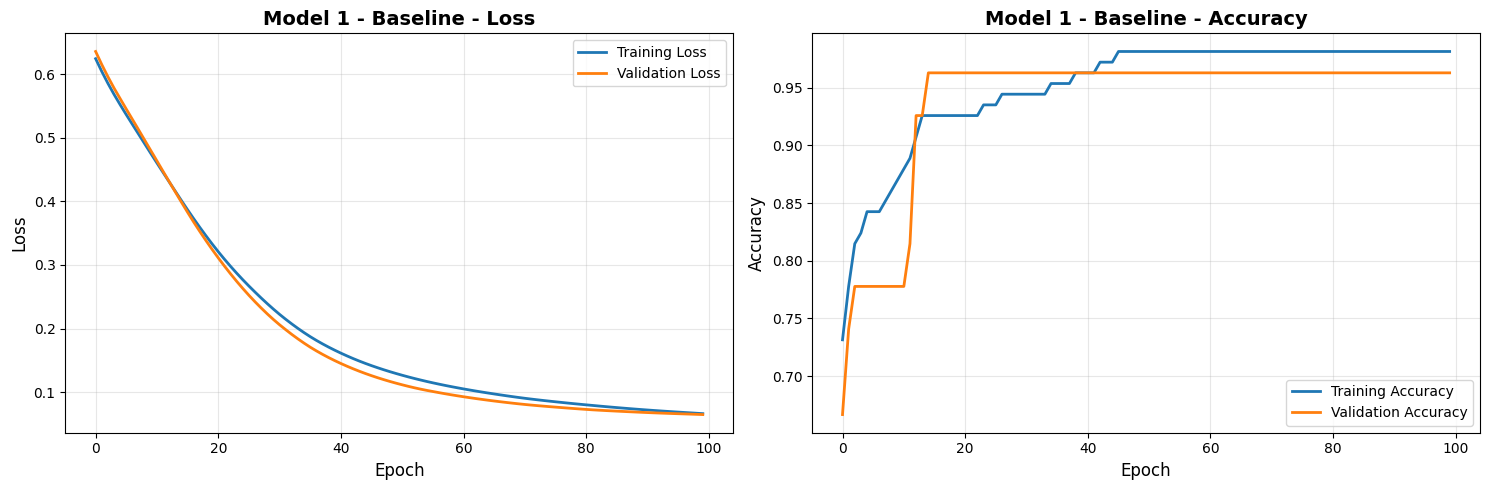


Best Validation Accuracy: 0.9630 (Epoch 15)


In [30]:
# Vẽ biểu đồ training history cho Model 1
def plot_training_history(history, model_name):
    """
    Vẽ biểu đồ loss và accuracy trong quá trình training

    Args:
        history: History object từ model.fit()
        model_name: Tên model để hiển thị trong title
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Loss
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot Accuracy
    axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # In ra best validation accuracy
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    print(f"\nBest Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")

# Vẽ biểu đồ cho Model 1
plot_training_history(history_1, 'Model 1 - Baseline')

## 6. Đánh giá Model 1 trên Test Set

ĐÁNH GIÁ MODEL 1 TRÊN TEST SET

Test Loss: 0.0501
Test Accuracy: 0.9828 (98.28%)

Accuracy trên test set: 0.9828 (98.28%)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Good     0.9630    1.0000    0.9811        26
      Normal     1.0000    0.9688    0.9841        32

    accuracy                         0.9828        58
   macro avg     0.9815    0.9844    0.9826        58
weighted avg     0.9834    0.9828    0.9828        58


CONFUSION MATRIX
[[26  0]
 [ 1 31]]


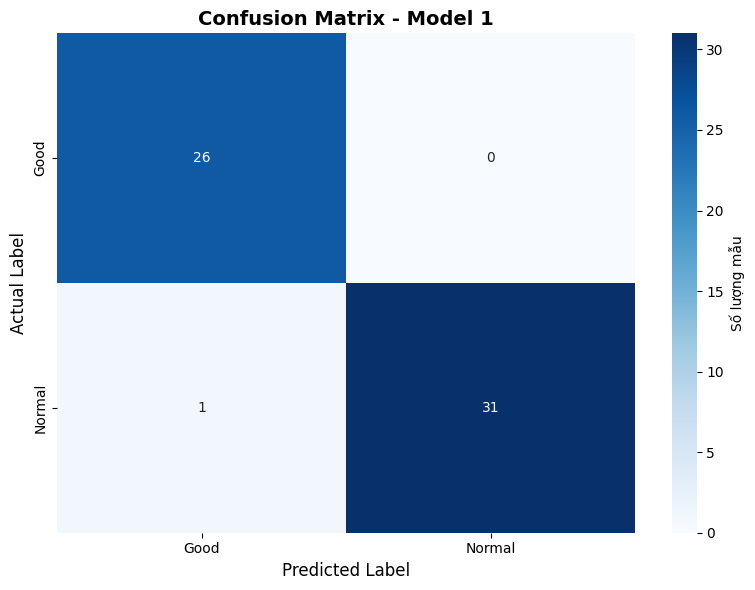


Phân tích chi tiết:
True Negative (Normal dự đoán đúng): 26
False Positive (Normal dự đoán sai thành Good): 0
False Negative (Good dự đoán sai thành Normal): 1
True Positive (Good dự đoán đúng): 31


In [31]:
# Evaluate Model 1 trên test set
print("=" * 60)
print("ĐÁNH GIÁ MODEL 1 TRÊN TEST SET")
print("=" * 60)

# Tính loss và accuracy trên test set
test_loss_1, test_accuracy_1 = model_1.evaluate(X_test, y_test, verbose=0)

print(f"\nTest Loss: {test_loss_1:.4f}")
print(f"Test Accuracy: {test_accuracy_1:.4f} ({test_accuracy_1*100:.2f}%)")

# Dự đoán trên test set
# predict() trả về xác suất [0, 1]
y_pred_proba_1 = model_1.predict(X_test, verbose=0)

# Chuyển xác suất thành class (0 hoặc 1)
# Nếu xác suất >= 0.5 -> class 1 (Good), ngược lại -> class 0 (Normal)
y_pred_1 = (y_pred_proba_1 >= 0.5).astype(int).flatten()

# Import metrics để đánh giá chi tiết
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Tính accuracy
accuracy_1 = accuracy_score(y_test, y_pred_1)
print(f"\nAccuracy trên test set: {accuracy_1:.4f} ({accuracy_1*100:.2f}%)")

# Classification Report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(
    y_test,
    y_pred_1,
    target_names=label_encoder.classes_,
    digits=4
))

# Confusion Matrix
cm_1 = confusion_matrix(y_test, y_pred_1)
print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60)
print(cm_1)

# Vẽ Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_1,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Số lượng mẫu'}
)
plt.title('Confusion Matrix - Model 1', fontsize=14, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Phân tích chi tiết confusion matrix
tn, fp, fn, tp = cm_1.ravel()
print("\nPhân tích chi tiết:")
print(f"True Negative (Normal dự đoán đúng): {tn}")
print(f"False Positive (Normal dự đoán sai thành Good): {fp}")
print(f"False Negative (Good dự đoán sai thành Normal): {fn}")
print(f"True Positive (Good dự đoán đúng): {tp}")

## 7. Demo dự đoán với Model 1 (Hiển thị tỷ lệ %)

In [32]:
def predict_student(model, gpa, study_hours, scaler, label_encoder):
    """
    Dự đoán loại học sinh dựa trên GPA và Study Hours
    Hiển thị kết quả với tỷ lệ % theo yêu cầu

    Args:
        model: Model đã train
        gpa: Điểm GPA của học sinh
        study_hours: Số giờ học của học sinh
        scaler: StandardScaler đã fit với training data
        label_encoder: LabelEncoder để decode nhãn

    Returns:
        predicted_class: Class dự đoán (Good/Normal)
        probability: Xác suất dự đoán
    """
    # Chuẩn bị input
    input_data = np.array([[gpa, study_hours]])

    # Chuẩn hóa input (phải dùng scaler đã fit với training data)
    input_scaled = scaler.transform(input_data)

    # Dự đoán xác suất
    probability = model.predict(input_scaled, verbose=0)[0][0]

    # Chuyển đổi xác suất thành class
    # probability >= 0.5 -> Good (1), ngược lại -> Normal (0)
    predicted_label = 1 if probability >= 0.5 else 0
    predicted_class = label_encoder.inverse_transform([predicted_label])[0]

    # In kết quả theo format yêu cầu
    print(f"\n{'='*60}")
    print(f"Thông tin học sinh:")
    print(f"  - GPA: {gpa}")
    print(f"  - Study Hours: {study_hours}")
    print(f"{'='*60}")
    print(f"Kết quả dự đoán:")

    if predicted_class == 'Good':
        # Nếu dự đoán là Good, hiển thị xác suất là Good
        percentage = probability * 100
        print(f"  {percentage:.2f}% là học sinh {predicted_class}")
    else:
        # Nếu dự đoán là Normal, hiển thị xác suất là Normal (1 - probability)
        percentage = (1 - probability) * 100
        print(f"  {percentage:.2f}% là học sinh {predicted_class}")

    print(f"{'='*60}\n")

    return predicted_class, probability

# Demo với một số mẫu từ test set
print("=" * 60)
print("DEMO DỰ ĐOÁN VỚI MODEL 1")
print("=" * 60)

# Lấy 5 mẫu ngẫu nhiên từ test set
np.random.seed(42)
random_indices = np.random.choice(len(X_test), size=5, replace=False)

for i, idx in enumerate(random_indices, 1):
    # Lấy original values (trước khi scale) từ X_test
    gpa_scaled = X_test[idx, 0]
    study_hours_scaled = X_test[idx, 1]

    # Inverse transform để lấy giá trị gốc
    original_values = scaler.inverse_transform([[gpa_scaled, study_hours_scaled]])
    gpa_original = original_values[0, 0]
    study_hours_original = original_values[0, 1]

    # Lấy actual class
    actual_label = y_test[idx]
    actual_class = label_encoder.inverse_transform([actual_label])[0]

    print(f"\nMẫu {i}:")
    print(f"Actual class: {actual_class}")

    # Dự đoán
    predicted_class, probability = predict_student(
        model_1,
        gpa_original,
        study_hours_original,
        scaler,
        label_encoder
    )

    # So sánh
    if predicted_class == actual_class:
        print("Dự đoán ĐÚNG!")
    else:
        print("Dự đoán SAI!")

print("\n" + "=" * 60)

DEMO DỰ ĐOÁN VỚI MODEL 1

Mẫu 1:
Actual class: Good

Thông tin học sinh:
  - GPA: 3.825
  - Study Hours: 20.0
Kết quả dự đoán:
  0.64% là học sinh Good

Dự đoán ĐÚNG!

Mẫu 2:
Actual class: Good

Thông tin học sinh:
  - GPA: 3.925
  - Study Hours: 15.0
Kết quả dự đoán:
  0.12% là học sinh Good

Dự đoán ĐÚNG!

Mẫu 3:
Actual class: Good

Thông tin học sinh:
  - GPA: 3.85
  - Study Hours: 10.0
Kết quả dự đoán:
  0.43% là học sinh Good

Dự đoán ĐÚNG!

Mẫu 4:
Actual class: Good

Thông tin học sinh:
  - GPA: 3.89
  - Study Hours: 12.0
Kết quả dự đoán:
  0.22% là học sinh Good

Dự đoán ĐÚNG!

Mẫu 5:
Actual class: Normal

Thông tin học sinh:
  - GPA: 3.6
  - Study Hours: 24.0
Kết quả dự đoán:
  3.70% là học sinh Normal

Dự đoán ĐÚNG!



## 8. Xây dựng Model 2: Neural Network cải tiến với Dropout

In [33]:
def create_model_2():
    """
    Tạo Model 2: Neural Network cải tiến với kiến trúc sâu hơn và Dropout

    Cải tiến so với Model 1:
    - Thêm 1 hidden layer (tổng 3 hidden layers)
    - Số neurons nhiều hơn ở các layer đầu
    - Sử dụng Dropout để tránh overfitting

    Kiến trúc:
    - Input layer: 2 neurons (gpa, study_hours)
    - Hidden layer 1: 32 neurons, ReLU activation
    - Dropout 1: 30% neurons bị tắt ngẫu nhiên
    - Hidden layer 2: 16 neurons, ReLU activation
    - Dropout 2: 20% neurons bị tắt ngẫu nhiên
    - Hidden layer 3: 8 neurons, ReLU activation
    - Output layer: 1 neuron, Sigmoid activation

    Returns:
        model: TensorFlow Sequential model
    """
    model = Sequential(name='Model_2_Improved')

    # Hidden layer 1: 32 neurons với ReLU
    # Nhiều neurons hơn để học được nhiều features phức tạp hơn
    model.add(Dense(
        units=32,
        activation='relu',
        input_shape=(2,),
        name='hidden_layer_1'
    ))

    # Dropout layer 1: tắt ngẫu nhiên 30% neurons
    # Dropout giúp tránh overfitting bằng cách ngăn model học thuộc lòng training data
    # Trong training: 30% neurons sẽ được set = 0 ngẫu nhiên
    # Trong inference: tất cả neurons hoạt động nhưng output được scale
    model.add(Dropout(
        rate=0.3,  # 30% neurons bị tắt
        name='dropout_1'
    ))

    # Hidden layer 2: 16 neurons với ReLU
    model.add(Dense(
        units=16,
        activation='relu',
        name='hidden_layer_2'
    ))

    # Dropout layer 2: tắt ngẫu nhiên 20% neurons
    model.add(Dropout(
        rate=0.2,  # 20% neurons bị tắt
        name='dropout_2'
    ))

    # Hidden layer 3: 8 neurons với ReLU
    # Layer thứ 3 để tinh chỉnh representation cuối cùng
    model.add(Dense(
        units=8,
        activation='relu',
        name='hidden_layer_3'
    ))

    # Output layer: 1 neuron với Sigmoid
    # Bắt buộc theo yêu cầu đề bài
    model.add(Dense(
        units=1,
        activation='sigmoid',
        name='output_layer'
    ))

    return model

# Tạo Model 2
model_2 = create_model_2()

# Compile model
model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# In ra kiến trúc model
print("=" * 60)
print("KIẾN TRÚC MODEL 2 - IMPROVED WITH DROPOUT")
print("=" * 60)
model_2.summary()

# Tính tổng số parameters
total_params_2 = model_2.count_params()
print(f"\nTổng số parameters: {total_params_2:,}")
print(f"So với Model 1: {total_params_2 - total_params:+,} parameters")

KIẾN TRÚC MODEL 2 - IMPROVED WITH DROPOUT


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Model_2_Improved"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)


Tổng số parameters: 769
So với Model 1: +576 parameters


In [34]:
# Training Model 2
print("=" * 60)
print("TRAINING MODEL 2")
print("=" * 60)

# Thiết lập callbacks tương tự Model 1
callbacks_2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'model_2_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    )
]

# Training Model 2
history_2 = model_2.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=callbacks_2,
    verbose=1
)

print("\nTraining Model 2 hoàn tất!")

TRAINING MODEL 2
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5325 - loss: 0.6894

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.5319 - loss: 0.6889 - val_accuracy: 0.4444 - val_loss: 0.6837
Epoch 2/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5625 - loss: 0.6799

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5680 - loss: 0.6800 - val_accuracy: 0.6667 - val_loss: 0.6678
Epoch 3/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6875 - loss: 0.6685

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6584 - loss: 0.6599 - val_accuracy: 0.7778 - val_loss: 0.6540
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7506 - loss: 0.6424 - val_accuracy: 0.7778 - val_loss: 0.6392
Epoch 5/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.6305

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7224 - loss: 0.6330 - val_accuracy: 0.8148 - val_loss: 0.6246
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7057 - loss: 0.6291 - val_accuracy: 0.8148 - val_loss: 0.6094
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8292 - loss: 0.5946 - val_accuracy: 0.7778 - val_loss: 0.5929
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7730 - loss: 0.5883 - val_accuracy: 0.8148 - val_loss: 0.5742
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8193 - loss: 0.5578 - val_accuracy: 0.8148 - val_loss: 0.5537
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9153 - loss: 0.5458 - val_accuracy: 0.8148 - val_loss: 0.5319
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8582 - loss: 0.5367 - val_accuracy: 0.8148 - val_loss: 0.5103
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8649 - loss: 0.4777 - val_accuracy: 0.8148 - val_loss: 0.4875
E

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8476 - loss: 0.4547 - val_accuracy: 0.9259 - val_loss: 0.4404
Epoch 15/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.4716

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8292 - loss: 0.4441 - val_accuracy: 0.9630 - val_loss: 0.4162
Epoch 16/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9111 - loss: 0.4162 - val_accuracy: 0.9630 - val_loss: 0.3925
Epoch 17/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9073 - loss: 0.3846 - val_accuracy: 0.9630 - val_loss: 0.3679
Epoch 18/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9379 - loss: 0.3541 - val_accuracy: 0.9630 - val_loss: 0.3435
Epoch 19/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8923 - loss: 0.3425 - val_accuracy: 0.9630 - val_loss: 0.3200
Epoch 20/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9532 - loss: 0.3212 - val_accuracy: 0.9630 - val_loss: 0.2994
Epoch 21/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9365 - loss: 0.3008 - val_accuracy: 0.9630 - val_loss: 0.2802
Epoch 22/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9584 - loss: 0.2863 - val_accuracy: 0.9630 - val_loss: 0.26

In [35]:
# Vẽ biểu đồ training history cho Model 2
plot_training_history(history_2, 'Model 2 - Improved with Dropout')


Best Validation Accuracy: 0.9630 (Epoch 15)


## 9. Đánh giá Model 2 trên Test Set

In [36]:
# Evaluate Model 2 trên test set
print("=" * 60)
print("ĐÁNH GIÁ MODEL 2 TRÊN TEST SET")
print("=" * 60)

# Tính loss và accuracy trên test set
test_loss_2, test_accuracy_2 = model_2.evaluate(X_test, y_test, verbose=0)

print(f"\nTest Loss: {test_loss_2:.4f}")
print(f"Test Accuracy: {test_accuracy_2:.4f} ({test_accuracy_2*100:.2f}%)")

# Dự đoán trên test set
y_pred_proba_2 = model_2.predict(X_test, verbose=0)
y_pred_2 = (y_pred_proba_2 >= 0.5).astype(int).flatten()

# Tính accuracy
accuracy_2 = accuracy_score(y_test, y_pred_2)
print(f"\nAccuracy trên test set: {accuracy_2:.4f} ({accuracy_2*100:.2f}%)")

# Classification Report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(
    y_test,
    y_pred_2,
    target_names=label_encoder.classes_,
    digits=4
))

# Confusion Matrix
cm_2 = confusion_matrix(y_test, y_pred_2)
print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60)
print(cm_2)

# Vẽ Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_2,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Số lượng mẫu'}
)
plt.title('Confusion Matrix - Model 2', fontsize=14, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Phân tích chi tiết confusion matrix
tn, fp, fn, tp = cm_2.ravel()
print("\nPhân tích chi tiết:")
print(f"True Negative (Normal dự đoán đúng): {tn}")
print(f"False Positive (Normal dự đoán sai thành Good): {fp}")
print(f"False Negative (Good dự đoán sai thành Normal): {fn}")
print(f"True Positive (Good dự đoán đúng): {tp}")

ĐÁNH GIÁ MODEL 2 TRÊN TEST SET

Test Loss: 0.0291
Test Accuracy: 0.9828 (98.28%)



Accuracy trên test set: 0.9828 (98.28%)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Good     0.9630    1.0000    0.9811        26
      Normal     1.0000    0.9688    0.9841        32

    accuracy                         0.9828        58
   macro avg     0.9815    0.9844    0.9826        58
weighted avg     0.9834    0.9828    0.9828        58


CONFUSION MATRIX
[[26  0]
 [ 1 31]]



Phân tích chi tiết:
True Negative (Normal dự đoán đúng): 26
False Positive (Normal dự đoán sai thành Good): 0
False Negative (Good dự đoán sai thành Normal): 1
True Positive (Good dự đoán đúng): 31


## 10. Demo dự đoán với Model 2

In [37]:
# Demo với Model 2
print("=" * 60)
print("DEMO DỰ ĐOÁN VỚI MODEL 2")
print("=" * 60)

for i, idx in enumerate(random_indices, 1):
    # Lấy original values (trước khi scale) từ X_test
    gpa_scaled = X_test[idx, 0]
    study_hours_scaled = X_test[idx, 1]

    # Inverse transform để lấy giá trị gốc
    original_values = scaler.inverse_transform([[gpa_scaled, study_hours_scaled]])
    gpa_original = original_values[0, 0]
    study_hours_original = original_values[0, 1]

    # Lấy actual class
    actual_label = y_test[idx]
    actual_class = label_encoder.inverse_transform([actual_label])[0]

    print(f"\nMẫu {i}:")
    print(f"Actual class: {actual_class}")

    # Dự đoán
    predicted_class, probability = predict_student(
        model_2,
        gpa_original,
        study_hours_original,
        scaler,
        label_encoder
    )

    # So sánh
    if predicted_class == actual_class:
        print("Dự đoán ĐÚNG!")
    else:
        print("Dự đoán SAI!")

print("\n" + "=" * 60)

DEMO DỰ ĐOÁN VỚI MODEL 2

Mẫu 1:
Actual class: Good

Thông tin học sinh:
  - GPA: 3.825
  - Study Hours: 20.0
Kết quả dự đoán:
  0.08% là học sinh Good

Dự đoán ĐÚNG!

Mẫu 2:
Actual class: Good

Thông tin học sinh:
  - GPA: 3.925
  - Study Hours: 15.0
Kết quả dự đoán:
  0.00% là học sinh Good

Dự đoán ĐÚNG!

Mẫu 3:
Actual class: Good

Thông tin học sinh:
  - GPA: 3.85
  - Study Hours: 10.0
Kết quả dự đoán:
  0.04% là học sinh Good

Dự đoán ĐÚNG!

Mẫu 4:
Actual class: Good

Thông tin học sinh:
  - GPA: 3.89
  - Study Hours: 12.0
Kết quả dự đoán:
  0.01% là học sinh Good

Dự đoán ĐÚNG!

Mẫu 5:
Actual class: Normal

Thông tin học sinh:
  - GPA: 3.6
  - Study Hours: 24.0
Kết quả dự đoán:
  2.62% là học sinh Normal

Dự đoán ĐÚNG!



## 11. So sánh 2 Models

In [38]:
# So sánh hiệu suất của 2 models
print("=" * 70)
print("SO SÁNH HIỆU SUẤT 2 MODELS")
print("=" * 70)

# Tạo bảng so sánh
comparison_data = {
    'Metric': ['Test Loss', 'Test Accuracy', 'Parameters'],
    'Model 1 (Baseline)': [
        f"{test_loss_1:.4f}",
        f"{test_accuracy_1:.4f} ({test_accuracy_1*100:.2f}%)",
        f"{total_params:,}"
    ],
    'Model 2 (Improved)': [
        f"{test_loss_2:.4f}",
        f"{test_accuracy_2:.4f} ({test_accuracy_2*100:.2f}%)",
        f"{total_params_2:,}"
    ],
    'Improvement': [
        f"{test_loss_1 - test_loss_2:+.4f}",
        f"{(test_accuracy_2 - test_accuracy_1)*100:+.2f}%",
        f"{total_params_2 - total_params:+,}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# So sánh Test Accuracy
models = ['Model 1\n(Baseline)', 'Model 2\n(Improved)']
accuracies = [test_accuracy_1, test_accuracy_2]
colors = ['#3498db', '#2ecc71']

bars = axes[0].bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('So sánh Test Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylim([0.85, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# Thêm giá trị lên trên mỗi cột
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.4f}\n({acc*100:.2f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# So sánh Test Loss
losses = [test_loss_1, test_loss_2]
bars = axes[1].bar(models, losses, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1].set_title('So sánh Test Loss', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Thêm giá trị lên trên mỗi cột
for bar, loss in zip(bars, losses):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{loss:.4f}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# Kết luận
print("\n" + "=" * 70)
print("KẾT LUẬN")
print("=" * 70)

improvement_acc = (test_accuracy_2 - test_accuracy_1) * 100
improvement_loss = test_loss_1 - test_loss_2

if improvement_acc > 0:
    print(f"\nModel 2 CẢI THIỆN được {improvement_acc:.2f}% về accuracy so với Model 1")
elif improvement_acc < 0:
    print(f"\nModel 2 GIẢM {abs(improvement_acc):.2f}% về accuracy so với Model 1")
else:
    print(f"\n= Model 2 có accuracy TƯƠNG ĐƯƠNG với Model 1")

if improvement_loss > 0:
    print(f"Model 2 GIẢM được {improvement_loss:.4f} về loss so với Model 1")
elif improvement_loss < 0:
    print(f"Model 2 TĂNG {abs(improvement_loss):.4f} về loss so với Model 1")
else:
    print(f"= Model 2 có loss TƯƠNG ĐƯƠNG với Model 1")

print(f"\nModel 2 có {total_params_2 - total_params:+,} parameters so với Model 1")
print("   Kiến trúc phức tạp hơn với Dropout giúp tránh overfitting")

print("\n" + "=" * 70)

SO SÁNH HIỆU SUẤT 2 MODELS

        Metric Model 1 (Baseline) Model 2 (Improved) Improvement
    Test Loss             0.0501             0.0291     +0.0210
Test Accuracy    0.9828 (98.28%)    0.9828 (98.28%)      +0.00%
   Parameters                193                769        +576



KẾT LUẬN

= Model 2 có accuracy TƯƠNG ĐƯƠNG với Model 1
Model 2 GIẢM được 0.0210 về loss so với Model 1

Model 2 có +576 parameters so với Model 1
   Kiến trúc phức tạp hơn với Dropout giúp tránh overfitting



## 12. Demo dự đoán với dữ liệu tùy chỉnh

In [39]:
# Demo dự đoán với dữ liệu người dùng nhập vào
print("=" * 70)
print("DEMO DỰ ĐOÁN VỚI DỮ LIỆU TÙY CHỈNH")
print("=" * 70)

# Các test cases tùy chỉnh
test_cases = [
    {"gpa": 3.9, "study_hours": 30, "description": "GPA cao, học nhiều"},
    {"gpa": 3.2, "study_hours": 8, "description": "GPA trung bình, học ít"},
    {"gpa": 3.6, "study_hours": 20, "description": "GPA khá, học vừa phải"},
    {"gpa": 4.0, "study_hours": 10, "description": "GPA tối đa, học ít"},
    {"gpa": 2.9, "study_hours": 15, "description": "GPA thấp, học vừa"}
]

for i, test_case in enumerate(test_cases, 1):
    print(f"\n{'='*70}")
    print(f"TEST CASE {i}: {test_case['description']}")
    print(f"{'='*70}")

    print("\n--- DỰ ĐOÁN VỚI MODEL 1 (BASELINE) ---")
    pred_class_1, prob_1 = predict_student(
        model_1,
        test_case['gpa'],
        test_case['study_hours'],
        scaler,
        label_encoder
    )

    print("\n--- DỰ ĐOÁN VỚI MODEL 2 (IMPROVED) ---")
    pred_class_2, prob_2 = predict_student(
        model_2,
        test_case['gpa'],
        test_case['study_hours'],
        scaler,
        label_encoder
    )

    # So sánh kết quả 2 models
    if pred_class_1 == pred_class_2:
        print(f"Cả 2 models đều dự đoán: {pred_class_1}")
    else:
        print(f"Models dự đoán khác nhau:")
        print(f"  - Model 1: {pred_class_1}")
        print(f"  - Model 2: {pred_class_2}")

print("\n" + "=" * 70)
print("HOÀN THÀNH DEMO!")
print("=" * 70)

DEMO DỰ ĐOÁN VỚI DỮ LIỆU TÙY CHỈNH

TEST CASE 1: GPA cao, học nhiều

--- DỰ ĐOÁN VỚI MODEL 1 (BASELINE) ---

Thông tin học sinh:
  - GPA: 3.9
  - Study Hours: 30
Kết quả dự đoán:
  0.17% là học sinh Good


--- DỰ ĐOÁN VỚI MODEL 2 (IMPROVED) ---

Thông tin học sinh:
  - GPA: 3.9
  - Study Hours: 30
Kết quả dự đoán:
  0.01% là học sinh Good

Cả 2 models đều dự đoán: Good

TEST CASE 2: GPA trung bình, học ít

--- DỰ ĐOÁN VỚI MODEL 1 (BASELINE) ---

Thông tin học sinh:
  - GPA: 3.2
  - Study Hours: 8
Kết quả dự đoán:
  0.00% là học sinh Normal


--- DỰ ĐOÁN VỚI MODEL 2 (IMPROVED) ---

Thông tin học sinh:
  - GPA: 3.2
  - Study Hours: 8
Kết quả dự đoán:
  0.00% là học sinh Normal

Cả 2 models đều dự đoán: Normal

TEST CASE 3: GPA khá, học vừa phải

--- DỰ ĐOÁN VỚI MODEL 1 (BASELINE) ---

Thông tin học sinh:
  - GPA: 3.6
  - Study Hours: 20
Kết quả dự đoán:
  3.32% là học sinh Normal


--- DỰ ĐOÁN VỚI MODEL 2 (IMPROVED) ---

Thông tin học sinh:
  - GPA: 3.6
  - Study Hours: 20
Kết quả dự đoá